# Evaluating ML Models as Agent Tools

In this notebook, we'll demonstrate how to evaluate traditional ML models when used as tools within LangGraph agents. We'll build a simple sentiment analysis agent and show multiple evaluation approaches:

1. **ML Model Metrics** - Precision, Recall, F1, Accuracy, Calibration on the model itself. Discussions on evaluating hyperaparameters.
2. **Single Step Evaluation** - Did the agent correctly select the right tool?
3. **End-to-End Evaluation** - Does the agent produce correct final responses?

This pattern applies to any ML model or tool called by an agent


## Evaluations: Key Concepts

**Evaluations** are a quantitative way to measure performance of agents, which is important because LLMs don't always behave predictably — small changes in prompts, models, or inputs can significantly impact results. Evaluations provide a structured way to identify failures, compare changes across different versions of your application, and build more reliable AI applications.

Evaluations are made up of three components:

1. A **dataset** with test inputs and expected outputs.
2. An **application or target function** that defines what you are evaluating, taking in inputs and returning the application output
3. **Evaluators** that score your target function's outputs.

![Evaluation](images/evals-conceptual.png)

In this notebook, we'll cover:

1. **ML Model Metrics**: Evaluate the ML tool directly with precision, recall, F1, accuracy
2. **Single Step**: Evaluate whether the agent selects the appropriate tool
3. **Final Response**: Evaluate the agent's end-to-end output quality


## Setup


### Install Dependencies

First, let's install the required packages. We need:
- `transformers` and `torch` for the HuggingFace sentiment model
- `langchain` and `langgraph` for building the agent
- `langsmith` and `openevals` for evaluations


### Load Environment Variables

**Use Case: Clinical Trial Participant Feedback Analysis**

In pharmaceutical research, analyzing sentiment from clinical trial participant feedback helps identify:
- Treatment satisfaction and efficacy perceptions
- Side effect severity and patient concerns  
- Early signals of safety issues
- Overall participant experience

We'll build an agent that uses sentiment analysis to classify this feedback, then evaluate it thoroughly.

Make sure you have the following environment variables set:
- `LANGSMITH_API_KEY` - For LangSmith evaluations
- `OPENAI_API_KEY` - For the LLM powering the agent


In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

from langchain.chat_models import init_chat_model

# Initialize the LLM for our agent
model = init_chat_model("openai:gpt-4o-mini")


## Part 1: Building the Sentiment Analysis Agent


### 1.1 Create the Sentiment Analysis Tool

We'll wrap a HuggingFace sentiment analysis model as a LangChain tool. This model (`distilbert-base-uncased-finetuned-sst-2-english`) classifies text as POSITIVE or NEGATIVE.


In [2]:
from transformers import pipeline
from langchain_core.tools import tool

# Initialize the HuggingFace sentiment pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis", 
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

@tool
def analyze_sentiment(text: str) -> dict:
    """
    Analyze the sentiment of the given text.
    Returns the sentiment label (POSITIVE/NEGATIVE) and confidence score.
    
    Args:
        text: The text to analyze for sentiment
    
    Returns:
        dict with 'label' (POSITIVE/NEGATIVE) and 'score' (confidence 0-1)
    """
    result = sentiment_pipeline(text)[0]
    return {"label": result["label"], "score": round(result["score"], 4)}

# Test the tool
print("Testing sentiment tool:")
print(analyze_sentiment.invoke("I love this product, it's amazing!"))
print(analyze_sentiment.invoke("This is terrible, I hate it."))


Device set to use mps:0


Testing sentiment tool:
{'label': 'POSITIVE', 'score': 0.9999}
{'label': 'NEGATIVE', 'score': 0.9996}


### 1.2 Create the Agent

Now let's create a simple agent using LangChain's `create_agent()` that can use our sentiment analysis tool.


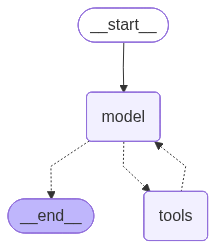

In [3]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver

# System prompt for our clinical trial feedback sentiment agent
sentiment_agent_prompt = """
You are a clinical trial feedback analyst that helps pharmaceutical researchers 
understand participant sentiment.

When given participant feedback, use the analyze_sentiment tool to classify it 
as positive or negative. After analysis, provide context on what the sentiment 
might indicate:
- Positive feedback often suggests treatment efficacy and good tolerability
- Negative feedback may signal side effects, lack of efficacy, or participant concerns

If the user asks something unrelated to clinical trial feedback analysis, politely 
explain that you specialize in analyzing participant sentiment from clinical studies.
"""

# Create checkpointer for conversation memory
checkpointer = MemorySaver()

# Create the agent
sentiment_agent = create_agent(
    model=model,
    tools=[analyze_sentiment],
    name="clinical_feedback_agent",
    system_prompt=sentiment_agent_prompt,
    checkpointer=checkpointer
)

sentiment_agent


### 1.3 Test the Agent


In [4]:
from langchain_core.messages import HumanMessage
from langsmith import uuid7

# Test with clinical trial participant feedback
config = {"configurable": {"thread_id": uuid7()}}

result = sentiment_agent.invoke(
    {"messages": [HumanMessage(content="Analyze this participant feedback: 'This treatment has been life-changing! My symptoms have completely disappeared and I feel better than I have in years. I'm so grateful I enrolled in this trial.'")]},
    config=config
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Analyze this participant feedback: 'This treatment has been life-changing! My symptoms have completely disappeared and I feel better than I have in years. I'm so grateful I enrolled in this trial.'
================================== Ai Message ==================================
Tool Calls:
  analyze_sentiment (call_Q8PUyiqSdJFtIszAW4EqLT4y)
 Call ID: call_Q8PUyiqSdJFtIszAW4EqLT4y
  Args:
    text: This treatment has been life-changing! My symptoms have completely disappeared and I feel better than I have in years. I'm so grateful I enrolled in this trial.
================================= Tool Message =================================
Name: analyze_sentiment

{"label": "POSITIVE", "score": 0.9962}
================================== Ai Message ==================================

The sentiment analysis indicates a **positive** sentiment with a high confidence score of 0.9962. 

This feedback suggests that t

In [5]:
# Test with an unrelated query (should politely decline)
config = {"configurable": {"thread_id": uuid7()}}

result = sentiment_agent.invoke(
    {"messages": [HumanMessage(content="What's the recommended dosage for ibuprofen?")]},
    config=config
)

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What's the recommended dosage for ibuprofen?
================================== Ai Message ==================================

I specialize in analyzing participant sentiment from clinical studies and not in providing medical dosages or recommendations. For dosage information regarding ibuprofen, I recommend consulting a healthcare professional or the official product instructions.


## Part 2: Evaluating the ML Model (Precision, Recall, F1, Accuracy)

Before evaluating the full agent, let's evaluate the ML model itself. This is important because:
- It establishes a baseline for model performance
- It helps identify if issues come from the ML model vs. the agent logic
- These metrics (precision, recall, F1) are standard for classification tasks


### 2.1 Create the Dataset

We'll create a dataset with labeled sentiment examples. In production, you'd use a curated test set.


In [6]:
from langsmith import Client

client = Client()

# Dataset with labeled clinical trial participant feedback
ml_examples = [
    # Positive feedback - treatment efficacy and satisfaction
    {"text": "The treatment has significantly improved my quality of life. I can finally sleep through the night.", "label": "POSITIVE"},
    {"text": "My symptoms have decreased by at least 80% since starting the trial medication.", "label": "POSITIVE"},
    {"text": "I'm thrilled with the results. The study coordinators were professional and supportive throughout.", "label": "POSITIVE"},
    {"text": "No significant side effects and noticeable improvement within the first two weeks.", "label": "POSITIVE"},
    {"text": "This is the first treatment that has actually worked for my condition. I'm grateful I enrolled.", "label": "POSITIVE"},
    {"text": "The medication was easy to take and the monitoring visits were well-organized.", "label": "POSITIVE"},
    {"text": "I experienced remarkable improvement in my mobility and reduced pain levels.", "label": "POSITIVE"},
    {"text": "Excellent care from the research team and promising results from the treatment.", "label": "POSITIVE"},
    
    # Negative feedback - side effects and concerns
    {"text": "I had to discontinue due to severe nausea and persistent headaches.", "label": "NEGATIVE"},
    {"text": "No noticeable improvement after 8 weeks. Very disappointed with the results.", "label": "NEGATIVE"},
    {"text": "The side effects were unbearable - constant fatigue and dizziness.", "label": "NEGATIVE"},
    {"text": "I experienced adverse reactions that significantly impacted my daily activities.", "label": "NEGATIVE"},
    {"text": "The treatment made my symptoms worse. I had to withdraw from the study.", "label": "NEGATIVE"},
    {"text": "Poor communication from the study team and long wait times at every visit.", "label": "NEGATIVE"},
    {"text": "Severe insomnia and mood changes since starting the medication.", "label": "NEGATIVE"},
    {"text": "I regret participating. The benefits did not outweigh the side effects.", "label": "NEGATIVE"},
]

dataset_name = "ML Model Evals: Clinical Trial Sentiment"

if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    client.create_examples(
        inputs=[{"text": ex["text"]} for ex in ml_examples],
        outputs=[{"label": ex["label"]} for ex in ml_examples],
        dataset_id=dataset.id
    )
    print(f"Created dataset: {dataset_name}")
else:
    print(f"Dataset already exists: {dataset_name}")

Dataset already exists: ML Model Evals: Clinical Trial Sentiment


### 2.2 Define the Target Function

For ML model evaluation, we run the tool directly (not the full agent).


In [7]:
def run_sentiment_model(inputs: dict) -> dict:
    """Run the sentiment model directly on input text."""
    result = sentiment_pipeline(inputs["text"])[0]
    return {"label": result["label"], "score": result["score"]}


### 2.3 Define ML Metric Evaluators

We'll create an evaluators for standard classification metrics. You may want to compute the overall pass rate or F1 score across all examples in the dataset—these are called **summary evaluators**, while per-row scores use **row-level evaluators**.

In [8]:
def classification_metrics(runs, examples):
    """Summary evaluator that computes precision, recall, F1 across all examples."""
    tp = fp = tn = fn = 0
    
    for run, example in zip(runs, examples):
        predicted = run.outputs.get("label")
        expected = example.outputs.get("label")
        
        if predicted == "POSITIVE" and expected == "POSITIVE":
            tp += 1
        elif predicted == "POSITIVE" and expected == "NEGATIVE":
            fp += 1
        elif predicted == "NEGATIVE" and expected == "NEGATIVE":
            tn += 1
        else:  # predicted NEGATIVE, expected POSITIVE
            fn += 1
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return {
        "results": [
            {"key": "precision", "score": precision},
            {"key": "recall", "score": recall},
            {"key": "f1_score", "score": f1},
            {"key": "accuracy", "score": accuracy},
        ]
    }

def correct(outputs: dict, reference_outputs: dict) -> bool:
    """Row-level correctness evaluator."""
    return outputs["label"] == reference_outputs["label"]

def calibration(outputs: dict, reference_outputs: dict) -> dict:
    """Row-level calibration evaluator - tracks confidence alongside correctness."""
    is_correct = outputs["label"] == reference_outputs["label"]
    confidence = outputs["score"]
    return {
        "results": [
            {"key": "confidence", "score": confidence},
            {"key": "correct", "score": 1 if is_correct else 0},
        ]
    }


### 2.4 Run the Evaluation


In [9]:
max_lengths_to_test = [64, 128, 256, 512]

for max_len in max_lengths_to_test:
    pipe = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        truncation=True,
        max_length=max_len
    )
    
    def run_model(inputs: dict) -> dict:
        result = pipe(inputs["text"])[0]
        return {"label": result["label"], "score": result["score"]}
    
    client.evaluate(
        run_model,
        data=dataset_name,
        evaluators=[correct, calibration],
        summary_evaluators=[classification_metrics],
        experiment_prefix=f"sentiment-maxlen-{max_len}",
        metadata={"max_length": max_len}
    )

Device set to use mps:0


View the evaluation results for experiment: 'sentiment-maxlen-64-5c9dbafc' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/ef87e6ea-e18e-42eb-b51e-ff7bb1971d21/compare?selectedSessions=77eab534-d922-4123-ae18-8a9a255c5a81




0it [00:00, ?it/s]

Device set to use mps:0


View the evaluation results for experiment: 'sentiment-maxlen-128-1b479aec' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/ef87e6ea-e18e-42eb-b51e-ff7bb1971d21/compare?selectedSessions=1769983b-4832-46a5-af02-7db656602053




0it [00:00, ?it/s]

Device set to use mps:0


View the evaluation results for experiment: 'sentiment-maxlen-256-1e194422' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/ef87e6ea-e18e-42eb-b51e-ff7bb1971d21/compare?selectedSessions=8d6abb4a-1a5f-4f70-843f-31d9ae4a8855




0it [00:00, ?it/s]

Device set to use mps:0


View the evaluation results for experiment: 'sentiment-maxlen-512-0dd2d87a' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/ef87e6ea-e18e-42eb-b51e-ff7bb1971d21/compare?selectedSessions=56409036-807f-4a20-8ae6-3951ea8d43d0




0it [00:00, ?it/s]

View the results in LangSmith! You should see accuracy, precision, recall, confidence, and calibration metrics aggregated across all examples.


## Part 3: Online vs Offline Evaluations

Before diving into agent-level evaluations, let's discuss two important evaluation paradigms:


### Offline Evaluations (What We've Done So Far)

**Offline evaluations** run before deployment on curated test datasets:

- Use `client.evaluate()` or `client.aevaluate()` 
- Run on a fixed dataset with known expected outputs
- Great for:
  - **Regression testing** - Ensure changes don't break existing functionality
  - **Comparing model versions** - A/B test different prompts or models
  - **CI/CD pipelines** - Automated quality gates before deployment
- Results visible in LangSmith **Experiments** view


### Online Evaluations (Production Monitoring)

**Online evaluations** run on real production traffic:

- Set up via **LangSmith Automations/Rules** in the UI
- **Sample-based** - Evaluate a percentage of production runs (e.g., 10%)
- Can use LLM-as-judge on live data
- Enables:
  - **Real-time monitoring** - Dashboards for production quality
  - **Alerting** - Get notified when quality drops
  - **Drift detection** - Catch issues with real user inputs
- Results visible in LangSmith **Monitoring** view


### When to Use Each

| Aspect | Offline | Online |
|--------|---------|--------|
| When | Before deployment | After deployment |
| Data | Curated test sets | Real user traffic |
| Coverage | 100% of test set | Sampled % of traffic |
| Purpose | Validate changes | Monitor production |
| Speed | Fast feedback | Continuous |

**Best practice**: Use both! Offline evals for development, online evals for production monitoring.


## Part 4: Single Step Evaluation

Now let's evaluate whether the agent correctly decides when to use the sentiment tool.

- Input: User query
- Output: Whether the correct tool was selected (or no tool for off-topic queries)

![single-step](../langgraph-101/images/single-step.png)


### 4.1 Create the Dataset


In [10]:
single_step_examples = [
    # Should call sentiment tool - clinical trial feedback
    {"query": "Analyze this feedback: 'The medication greatly improved my symptoms'", "should_call_tool": True},
    {"query": "What's the sentiment of: 'I experienced severe nausea and had to withdraw'", "should_call_tool": True},
    {"query": "Is this participant feedback positive or negative: 'No side effects and feeling much better'", "should_call_tool": True},
    {"query": "Classify the sentiment: 'The treatment was ineffective and I saw no improvement'", "should_call_tool": True},
    {"query": "How does this participant feel: 'I'm grateful I enrolled, life-changing results'", "should_call_tool": True},
    
    # Should NOT call sentiment tool - off-topic questions
    {"query": "What's the recommended dosage for the study medication?", "should_call_tool": False},
    {"query": "When is my next clinic visit scheduled?", "should_call_tool": False},
    {"query": "Can I take ibuprofen while on the trial?", "should_call_tool": False},
    {"query": "What are the inclusion criteria for the study?", "should_call_tool": False},
    {"query": "Who is the principal investigator?", "should_call_tool": False},
]

single_step_dataset_name = "ML Model Evals: Clinical Trial Single Step"

if not client.has_dataset(dataset_name=single_step_dataset_name):
    dataset = client.create_dataset(dataset_name=single_step_dataset_name)
    client.create_examples(
        inputs=[{"query": ex["query"]} for ex in single_step_examples],
        outputs=[{"should_call_tool": ex["should_call_tool"]} for ex in single_step_examples],
        dataset_id=dataset.id
    )
    print(f"Created dataset: {single_step_dataset_name}")
else:
    print(f"Dataset already exists: {single_step_dataset_name}")

Dataset already exists: ML Model Evals: Clinical Trial Single Step


### 4.2 Define the Target Function

We'll run the agent and check if it called the sentiment tool.


In [11]:
async def run_agent_single_step(inputs: dict) -> dict:
    """Run agent and check if sentiment tool was called."""
    config = {"configurable": {"thread_id": uuid7()}}
    
    result = await sentiment_agent.ainvoke(
        {"messages": [HumanMessage(content=inputs["query"])]},
        config=config
    )
    
    # Check if analyze_sentiment tool was called
    tool_called = False
    for message in result["messages"]:
        if hasattr(message, 'tool_calls') and message.tool_calls:
            for tc in message.tool_calls:
                if tc.get("name") == "analyze_sentiment":
                    tool_called = True
                    break
    
    return {"tool_called": tool_called}


### 4.3 Define the Evaluator


In [12]:
def tool_selection_evaluator(outputs: dict, reference_outputs: dict) -> dict:
    """Check if the agent correctly decided whether to call the tool."""
    expected = reference_outputs["should_call_tool"]
    actual = outputs["tool_called"]
    is_correct = expected == actual
    return {"key": "correct_tool_selection", "score": 1 if is_correct else 0}


### 4.4 Run the Evaluation


In [13]:
experiment_results = await client.aevaluate(
    run_agent_single_step,
    data=single_step_dataset_name,
    evaluators=[tool_selection_evaluator],
    experiment_prefix="sentiment-single-step",
    max_concurrency=4
)


View the evaluation results for experiment: 'sentiment-single-step-a075ff9f' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/e00f955a-57a1-4c58-a99c-8dacf1432a63/compare?selectedSessions=7f56a43b-8b63-4ff9-90bb-c10404b4e790




0it [00:00, ?it/s]

## Part 5: End-to-End Evaluation (Final Response)

Finally, let's evaluate the agent's complete responses. This treats the agent as a black box and evaluates whether it produces correct, helpful responses.

- Input: User query
- Output: Agent's final response

![final-response](../langgraph-101/images/final-response.png)


### 5.1 Create the Dataset


In [23]:
e2e_examples = [
    # Positive feedback - efficacy
    {
        "query": "Analyze this feedback: 'The treatment has dramatically reduced my symptoms. I finally feel like myself again.'",
        "expected_response": "Positive sentiment indicating strong treatment efficacy and improved quality of life."
    },
    {
        "query": "Analyze this feedback: 'No side effects and my pain levels have dropped significantly since week 2.'",
        "expected_response": "Positive sentiment indicating good tolerability and measurable improvement."
    },
    {
        "query": "Analyze this feedback: 'The study team was excellent and the medication worked better than anything I've tried before.'",
        "expected_response": "Positive sentiment about both treatment efficacy and study experience."
    },
    
    # Negative feedback - side effects
    {
        "query": "Analyze this feedback: 'I had to withdraw due to constant nausea and severe headaches.'",
        "expected_response": "Negative sentiment indicating tolerability issues leading to discontinuation."
    },
    {
        "query": "Analyze this feedback: 'No improvement after 8 weeks. Very disappointed with the results.'",
        "expected_response": "Negative sentiment indicating lack of efficacy."
    },
    {
        "query": "Analyze this feedback: 'The side effects were worse than my original symptoms. I regret enrolling.'",
        "expected_response": "Negative sentiment indicating poor risk-benefit experience."
    },
    
    # Mixed/nuanced feedback
    {
        "query": "Analyze this feedback: 'The medication helped my condition but the fatigue was hard to manage.'",
        "expected_response": "Mixed but net positive - efficacy achieved with manageable side effects."
    },
    {
        "query": "Analyze this feedback: 'Some improvement but not sure if it's worth continuing given the stomach issues.'",
        "expected_response": "Uncertain/negative sentiment - questioning whether to continue."
    },
]

e2e_dataset_name = "ML Model Evals: Clinical Trial E2E v2"

if not client.has_dataset(dataset_name=e2e_dataset_name):
    dataset = client.create_dataset(dataset_name=e2e_dataset_name)
    client.create_examples(
        inputs=[{"query": ex["query"]} for ex in e2e_examples],
        outputs=[{"response": ex["response"]} for ex in e2e_examples],
        dataset_id=dataset.id
    )
    print(f"Created dataset: {e2e_dataset_name}")
else:
    print(f"Dataset already exists: {e2e_dataset_name}")

Dataset already exists: ML Model Evals: Clinical Trial E2E v2


### 5.2 Define the Target Function


In [24]:
import json

async def run_agent_e2e(inputs: dict) -> dict:
    """Run the full agent and return the final response."""
    config = {"configurable": {"thread_id": uuid7()}}
    
    result = await sentiment_agent.ainvoke(
        {"messages": [HumanMessage(content=inputs["query"])]},
        config=config
    )
    
    # Just return the final response
    return {"response": result["messages"][-1].content}

### 5.3 Define the Evaluators


In [25]:
from openevals.llm import create_async_llm_as_judge
from openevals.prompts import CORRECTNESS_PROMPT

# LLM-as-judge for response correctness
correctness_evaluator = create_async_llm_as_judge(
    prompt=CORRECTNESS_PROMPT,
    feedback_key="correctness",
    judge=model
)


### 5.4 Run the Evaluation


In [26]:
experiment_results = await client.aevaluate(
    run_agent_e2e,
    data=e2e_dataset_name,
    evaluators=[correctness_evaluator],
    experiment_prefix="sentiment-e2e",
    max_concurrency=4
)


View the evaluation results for experiment: 'sentiment-e2e-5c81c90c' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/25dac4d7-e499-4e2a-813a-520d86bdcbea/compare?selectedSessions=1901c773-501d-49aa-acd7-81d608f5b1dd




0it [00:00, ?it/s]

## Summary

In this notebook, we demonstrated a comprehensive evaluation strategy for ML models used as agent tools:

1. **ML Model Metrics** - Evaluated the sentiment classifier directly with precision, recall, accuracy, and confidence scores

2. **Online vs Offline Evals** - Discussed when to use offline evaluations (development) vs online evaluations (production monitoring)

3. **Single Step Evaluation** - Verified the agent correctly decides when to call the sentiment tool

4. **End-to-End Evaluation** - Assessed the agent's complete responses using LLM-as-judge and custom evaluators

### Key Takeaways

- **Layer your evaluations**: Test the ML model, the tool selection logic, and the full agent separately
- **Use appropriate metrics**: Classification metrics for ML models, correctness for agent responses
- **Combine evaluators**: Use both deterministic checks and LLM-as-judge for comprehensive coverage
- **View results in LangSmith**: All evaluation results are tracked and visualized in the Experiments view

### Next Steps

- Set up **online evaluations** in LangSmith for production monitoring
- Add more sophisticated ML models (toxicity, entity extraction, etc.)
- Create **regression test suites** that run in CI/CD
- Experiment with different prompts and compare results across experiments
